In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from matplotlib.ticker import MaxNLocator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


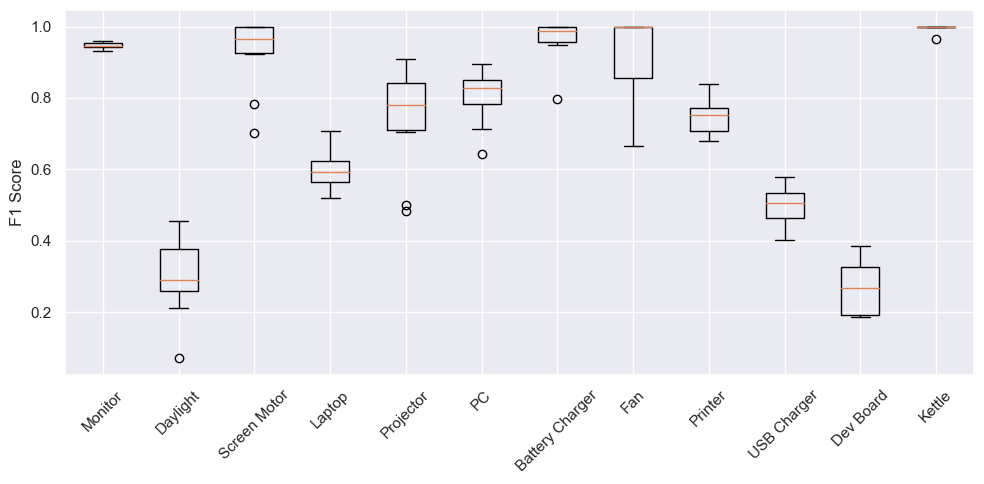

In [11]:
def vis_k_fold():

    runs = os.listdir("../models")
    k_fold = None
    for run in runs[:]:
        if "K_Fold" in run:
            k_fold = run
    k_fold_runs = os.listdir(os.path.join("../models", k_fold))

    mean_df = None
    concat_df = None
    for i, fold in enumerate(sorted(k_fold_runs)):

        df = pd.read_csv(os.path.join("../models", k_fold, fold, 'results.csv'), index_col=0)
        if mean_df is None:
            mean_df = df.loc['Mean'].rename("Fold 0")
            concat_df = df
        else:
            mean_df = pd.concat((mean_df, df.loc['Mean'].rename(f"Fold {i}")), axis=1)
            concat_df = pd.concat((concat_df, df), axis=0)

    with open("tables/k_fold_table.tex", 'w') as fd:
        mean_df.transpose().to_latex(fd)

    result_dict = {}
    for appliance in set(concat_df.index):
        if 'Mean' not in appliance:
            result_dict[appliance] = concat_df.loc[appliance]['F1'].values

    sns.set(rc={'figure.figsize':(10,5)})
    fig, ax = plt.subplots()
    ax.boxplot(result_dict.values())
    ax.set_xticklabels(result_dict.keys(), rotation = 45)
    ax.set_ylabel('F1 Score')
    plt.tight_layout()
    plt.savefig('figures/f1_k_fold_box.svg', dpi = 300)
    plt.show()

vis_k_fold()

In [12]:
def feature_chaining(model, folder):
    runs = os.listdir(f"../models/{folder}")

    run_val_dict = {}
    run_test_dict = {}
    for run in runs[:]:
        if model in run:
            exp_runs = os.listdir(os.path.join(f"../models/{folder}", run))
            features = run.split('[')[1].split(']')[0].replace('_', '\n')[14:]
            val_f1 = 0
            test_f1 = 0
            for exp_run in exp_runs:

                event_acc = EventAccumulator(os.path.join(f"../models/{folder}", run, exp_run))
                event_acc.Reload()
                try:
                    _, _, vals = zip(*event_acc.Scalars('Hparam/F1'))
                    run_val_f1 = vals[0]
                    _, _, vals = zip(*event_acc.Scalars('Test/Averaged F1_Score'))
                    run_test_f1 = vals[0]
                except KeyError:
                    print(os.path.join(run, exp_run))
                    run_val_f1 = 0
                    run_test_f1 = 0

                if val_f1 < run_val_f1:
                    val_f1 = run_val_f1
                    test_f1 = run_test_f1

            run_val_dict[val_f1] = features
            run_test_dict[test_f1] = features

    run_val_dict = collections.OrderedDict(sorted(run_val_dict.items()))
    run_test_dict = collections.OrderedDict(sorted(run_test_dict.items()))

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    idx = int(len(run_val_dict.values()) / 2)
    if len(run_val_dict.values()) % 2 == 1:
        idx +=1

    for i in range(0,2):
        df_val = pd.DataFrame({
            'Features': list(run_val_dict.values())[idx * i:idx * (i+1)],
            'F1': np.round_(np.asarray(list(run_val_dict.keys()), dtype=float), 2)[idx * i:idx * (i+1)],
            })
        df_test = pd.DataFrame({
            'Features': list(run_val_dict.values())[idx * i:idx * (i+1)],
            'F1': np.round_(np.asarray(list(run_val_dict.keys()), dtype=float), 2)[idx * i:idx * (i+1)],
            })

        sns.set(rc={'figure.figsize':(15,5)})
        #ax = sns.barplot(ax=axes[i], x='Features', y='F1', data=df_val, palette="Blues_d")
        ax = sns.barplot(ax=axes[i], x='Features', y='F1', data=df_test, palette="Blues_d")

        for index, row in df_val.iterrows():
            ax.text(row.name, row.values[1], row.values[1], color='black', ha="center")

        for item in ax.get_xticklabels():
            item.set_rotation(90)

    plt.tight_layout()
    plt.savefig(f'figures/{model}_val_feature_chaining.svg', dpi=300, bbox_extra_artists=(ax,), bbox_inches='tight')
    plt.show()

for model in ['CNN1D', 'LSTM', 'RESNET', 'DENSE']:
    feature_chaining(model, 'single_models')

ValueError: min() arg is an empty sequence

In [ ]:
def appliance_table(runs, name_prefix, folder="", exp_suffix=""):
    df = None
    for i, run in enumerate(runs):
        tmp = pd.read_csv(os.path.join('../models', folder, f'{run}{exp_suffix}', 'results.csv'), index_col=0)
        df = pd.concat([df, tmp[['F1', 'Accuracy']]], axis=1)

    if folder != "":
        folder = '_' + folder
    with open(f"tables/{name_prefix}{exp_suffix}{folder}_app_table.tex", 'w') as fd:
        df.round(2).to_latex(fd)

def mean_table(runs, name_prefix, folder="", exp_suffix=""):
    labels = ['CNN', 'LSTM', 'ResNet', 'DenseNet']
    df = None
    for i, run in enumerate(runs):
        tmp = pd.read_csv(os.path.join('../models', folder, f'{run}{exp_suffix}', 'results.csv'), index_col=0)
        df = pd.concat([df, tmp.loc['Mean'].rename(labels[i])], axis=1)

    if folder != "":
        folder = '_' + folder
    with open(f"tables/{name_prefix}{exp_suffix}{folder}_table.tex", 'w') as fd:
        df.transpose().round(2).to_latex(fd)

runs=[
    "CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19",
    "LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23",
    "RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20",
    "DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12"
]
#appliance_table(runs, 'single', 'single_models')
#mean_table(runs, 'single', 'single_models')

runs=[
    "Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_agg-100_epoch-1_noniid",
    "Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-100_epoch-1_noniid",
    "Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_agg-100_epoch-1_noniid",
    "Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_agg-100_epoch-1_noniid"
]
appliance_table(runs, 'noniid', folder="librosa", exp_suffix="_no_stopping_cosine")
mean_table(runs, 'noniid', folder="librosa", exp_suffix="_no_stopping_cosine")

In [ ]:
def show_train_val_loss(folder):
    runs = sorted(os.listdir(os.path.join('loss', folder)))

    sns.set(rc={'figure.figsize':(15,5)})
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, run in enumerate(runs):
        df = pd.read_csv(os.path.join('loss', folder, run))
        if 'Train' in run:
            axes[0].plot(df['Value'])
        else:
            axes[1].plot(df['Value'])

    axes[0].set_ylabel('Train Loss')
    axes[1].set_ylabel('Validation Loss')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.text(0.5, 0, 'Epochs', ha='center', va='center')
    axes[0].legend(['CNN', 'DenseNet', 'LSTM', 'ResNet'])
    axes[1].legend(['CNN', 'DenseNet', 'LSTM', 'ResNet'])
    plt.tight_layout()
    plt.savefig(f'figures/single_loss.svg', dpi=300)
    plt.show()

show_train_val_loss('single_models')

In [ ]:
def show_val_loss(folder):
    runs = sorted(os.listdir(os.path.join('loss', folder)))

    sns.set(rc={'figure.figsize':(15,5)})
    fig, axes = plt.subplots(1, 1, figsize=(10, 4))
    for i, run in enumerate(runs):
        if 'run' in run:
            df = pd.read_csv(os.path.join('loss', folder, run))
            axes.plot(df['Value'])

    axes.set_ylabel('Validation Loss')
    axes.set_xlabel('Aggregation Steps')
    plt.tight_layout()
    plt.legend(['CNN', 'DenseNet', 'LSTM', 'ResNet'])
    plt.savefig(f"figures/{folder.replace('/', '_')}_loss.svg", dpi=300)
    plt.show()

show_val_loss('non_iid_no_stopping_cosine_steps_4/librosa')

In [ ]:
steps = [1, 4, 10]
aggs = [400, 100, 40]
for i in range(len(steps)):
    models = [
        f"Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine",
        f"Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine",
        f"Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine",
        f"Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine"
    ]
    mean_table(models, str(steps[i]), folder='librosa')

In [ ]:
def comp_client_table(run):
    df_central = None

    central_runs = os.listdir(os.path.join('..', run, 'single_medal'))
    for i, central_run in enumerate(central_runs):
        tmp = pd.read_csv(os.path.join('..', run, 'single_medal', central_run, 'results.csv'), index_col=0)
        df_central = pd.concat([df_central, tmp.loc['Mean'][['F1', 'Accuracy']].rename(f'Client {i+1}')], axis=1)

    df_fed = None
    fed_runs = os.listdir(os.path.join('..', run))
    for i, fed_run in enumerate(sorted(fed_runs)):
        if 'test' in fed_run and 'event' not in fed_run:
            tmp = pd.read_csv(os.path.join('..', run, fed_run, 'results.csv'), index_col=0)
            df_fed = pd.concat([df_fed, tmp.loc['Mean'][['F1', 'Accuracy']].rename(f"Client {fed_run[-2:].replace('_','')}")], axis=1)

    df_percentage = df_fed.transpose()['F1'] / df_central.transpose()['F1'] * 100
    df_percentage = pd.concat([df_percentage, df_fed.transpose()['Accuracy'] / df_central.transpose()['Accuracy'] * 100], axis=1).round(0)

    df = pd.concat([df_central, df_fed]).round(2).transpose()
    df = pd.concat([df, df_percentage], axis=1)
    print(df)

    with open(f"tables/fed_librosa_table.tex", 'w') as fd:
        df.to_latex(fd)

comp_client_table("models/librosa/Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-100_step-4_noniid_no_stopping_cosine_exp")

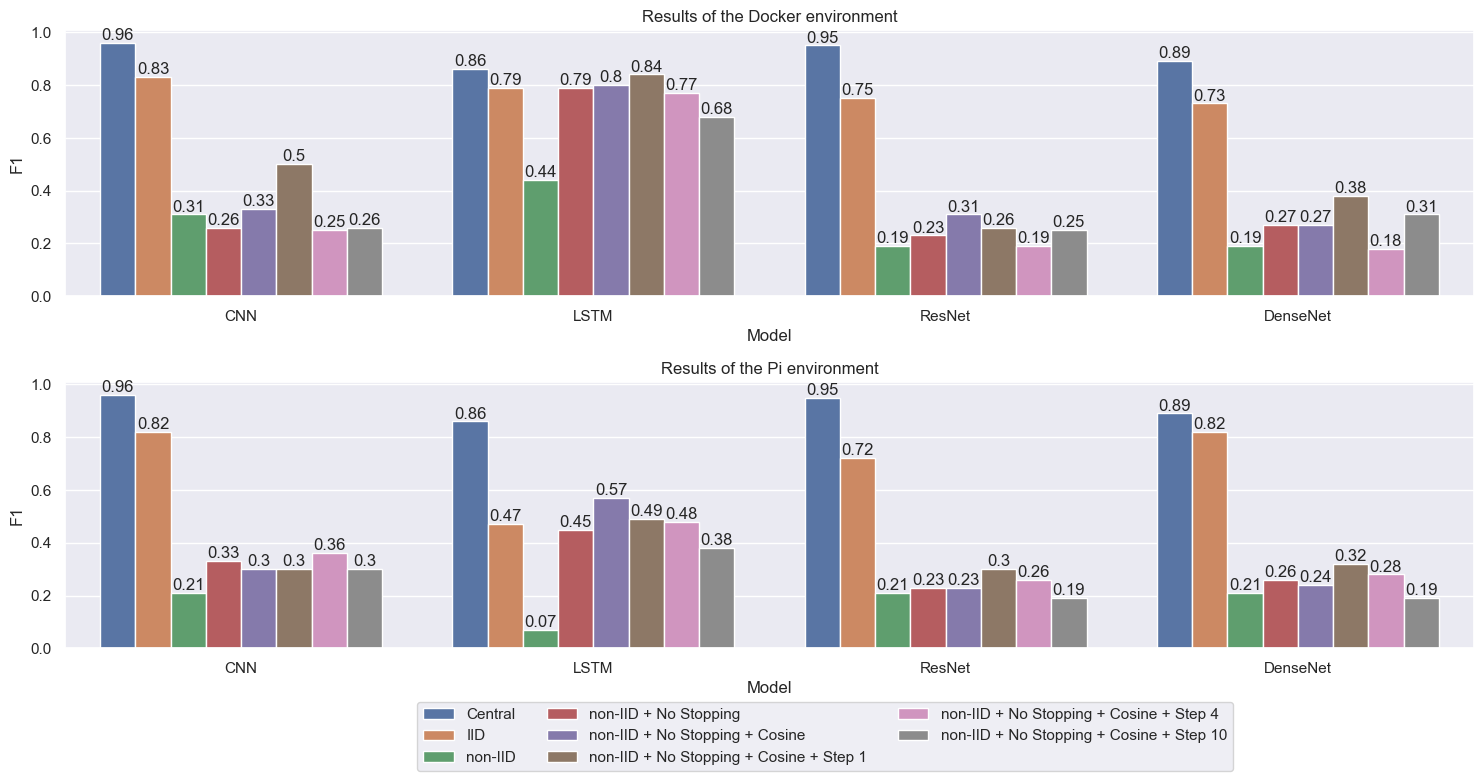

In [18]:
def global_comp():

    fig, axes = plt.subplots(2, 1)
    sns.set(rc={'figure.figsize':(15,10)})

    steps = [1, 4, 10]
    aggs = [400, 100, 40]
    labels = ['CNN', 'LSTM', 'ResNet', 'DenseNet']
    appendix_list = ['single_models', '', 'librosa']
    for j in range(2):
        df = pd.DataFrame()
        exp_list = []
        for k in range(len(steps)+5):
            if k == 0:
                appendix = appendix_list[0]
                models=[
                    "CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19",
                    "LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23",
                    "RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20",
                    "DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12"
                ]
                exp_list.extend(['Central'] * 4)
            elif k == 1:
                appendix = appendix_list[j+1]
                models=[
                    "Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_agg-100_epoch-1_iid",
                    "Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-100_epoch-1_iid",
                    "Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_agg-100_epoch-1_iid",
                    "Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_agg-100_epoch-1_iid"
                ]
                exp_list.extend(['IID'] * 4)
            elif k == 2:
                models=[
                    "Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_agg-100_epoch-1_noniid",
                    "Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-100_epoch-1_noniid",
                    "Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_agg-100_epoch-1_noniid",
                    "Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_agg-100_epoch-1_noniid"
                ]
                exp_list.extend(['non-IID'] * 4)
            elif k == 3:
                models=[
                    "Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_agg-100_epoch-1_noniid_no_stopping",
                    "Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-100_epoch-1_noniid_no_stopping",
                    "Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_agg-100_epoch-1_noniid_no_stopping",
                    "Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_agg-100_epoch-1_noniid_no_stopping"
                ]
                exp_list.extend(['non-IID + No Stopping'] * 4)
            elif k == 4:
                models=[
                    "Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_agg-100_epoch-1_noniid_no_stopping_cosine",
                    "Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-100_epoch-1_noniid_no_stopping_cosine",
                    "Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_agg-100_epoch-1_noniid_no_stopping_cosine",
                    "Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_agg-100_epoch-1_noniid_no_stopping_cosine"
                ]
                exp_list.extend(['non-IID + No Stopping + Cosine'] * 4)
            else:
                i = k - 5

                models = [
                    f"Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine",
                    f"Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine",
                    f"Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine",
                    f"Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_agg-{aggs[i]}_step-{steps[i]}_noniid_no_stopping_cosine"
                ]
                exp_list.extend([f'non-IID + No Stopping + Cosine + Step {steps[i]}'] * 4)

            for i, run in enumerate(models):
                tmp = pd.read_csv(os.path.join('../models', appendix, run, 'results.csv'), index_col=0)
                df = pd.concat([df, tmp.loc['Mean'].rename(labels[i])], axis=1)

        df = df.T
        df['Method'] = exp_list
        df['Model'] = df.index
        df['F1'] = df['F1'].round(2)


        ax = sns.barplot(ax=axes[j], x='Model', y='F1', hue='Method', data=df)
        ax.legend([],[], frameon=False)

        for container in ax.containers:
            ax.bar_label(container)

    plt.legend(bbox_to_anchor=(0.25, -0.2), loc=2, borderaxespad=0., ncol=3)
    axes[0].set_title('Results of the Docker environment')
    axes[1].set_title('Results of the Pi environment')

    plt.tight_layout()
    plt.savefig('figures/f1_comparison.svg')
    plt.show()

global_comp()


